In [75]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

### Подготовка данных

##### Получение данных для анализа

In [72]:
#PATH_DATA = './data/data_part.json'
PATH_DATA = './data/data.json'
PATH_MODEL = './data/model__tree'
PATH_MODEL_DOT = './data/model__tree.dot'

dataRead = []
with open(PATH_DATA, 'r', encoding='utf-8') as jsonfile:    
    dataRead = json.load(jsonfile)
    
data = pd.DataFrame(data=dataRead)
data.head()

,Stylist,Visagiste,Unknown,Skilled,Advertising,Clip,Мale,Fashionshow,Videoshooting,Male,Photographer,Model,TVShow,Female,Photoshooting,Casting,Text
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,мужчин актер съемок клип съемк клип ищ геро му...
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,вниман москв т взлет ориентировочн девушк лет ...
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,х ф данил козловск пада аист мужчин лет рост р...
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,нов шанс попаст кастинг супер телевикторин уга...
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,кастинг июл девушек размер одежд парн работ ию...


##### Получение целевого признака data_y

In [46]:
columns = 'TVShow'
data_y = data[columns]
data_y.value_counts()

0    4787
1     549
Name: TVShow, dtype: int64

##### Получение данных для обучения data_x

In [47]:
data_x = data['Text']
data_x.shape

(5336,)

##### Разделение данных на train_x,train_y и test_x,test_y

In [48]:
TRAIN_PERCENT = 70
delimiter = int(len(data_y) * TRAIN_PERCENT / 100)

train_x = data_x[:delimiter]
test_x = data_x[delimiter:]
train_y = data_y[:delimiter]
test_y = data_y[delimiter:]

### Деревья преобразование текста CountVectorizer

In [49]:
model_vectorizer = CountVectorizer()
vectorizer = model_vectorizer.fit(train_x)
feature_names = model_vectorizer.get_feature_names()

##### Подготовка данных

In [50]:
train_x = pd.DataFrame(data=vectorizer.transform(train_x).toarray(), columns=feature_names)
train_y = train_y 

test_x = pd.DataFrame(data=vectorizer.transform(test_x).toarray(), columns=feature_names)
test_y = test_y

##### Обучение модели и сохранение в файл

In [51]:
%%time
logit = DecisionTreeClassifier(random_state=17, max_depth=6, max_features=1)
logit.fit(train_x, train_y)

with open(PATH_MODEL, 'wb') as f:
    pickle.dump(logit, f)

CPU times: user 61.4 ms, sys: 28.1 ms, total: 89.5 ms
Wall time: 91 ms


##### Чтение готовой модели с файла

In [52]:
with open(PATH_MODEL, 'rb') as f:
    logit = pickle.load(f)

##### Лучшее значение max_depth и соответствующее качество на кросс-валидации

In [53]:
%%time
logit_test = DecisionTreeClassifier(random_state=17)
logit_test.fit(train_x, train_y)
param_grid_logit =  {'max_depth': np.arange(1, 11), 'max_features':[.5, .7, 1]}
grid_logit = GridSearchCV(logit_test, param_grid_logit, cv=5, n_jobs=-1)
grid_logit.fit(train_x, train_y)

CPU times: user 2.93 s, sys: 386 ms, total: 3.32 s
Wall time: 58.7 s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 1

In [33]:
grid_logit.best_params_, grid_logit.best_score_

({'max_depth': 6, 'max_features': 1}, 0.9571428571428571)

### Анализ модели

##### Доли правильных ответов на обучающей и тестовой выборках

In [43]:
round(logit.score(train_x, train_y), 3), round(logit.score(test_x, test_y), 3),

(0.971, 0.967)

In [54]:
valid_pred = logit.predict_proba(test_x)[:,1]
roc_auc = roc_auc_score(test_y, valid_pred)
print('Качество модели относительно тестовой выборки: ' + str(roc_auc))

Качество модели относительно тестовой выборки: 0.5013736263736264


##### Коэффициенты модели

In [73]:
export_graphviz(logit, out_file=PATH_MODEL_DOT,
               feature_names=feature_names, filled=True,)

### Првоерка модели на данных 

In [90]:
texts = ["asfsadasdfsd sd gsdg sdg sdgsdg sdg", "тв шоу для актеров"]
result_x = train_x = pd.DataFrame(data=vectorizer.transform(texts).toarray(), columns=feature_names)
result = logit.predict_proba(result_x)
print("Вероятность - текст")
for i in range(0, len(texts)):
    print(str(result[i][1]) + " : " + texts[i])

Вероятность - текст
0.10783261802575107 : asfsadasdfsd sd gsdg sdg sdgsdg sdg
0.10783261802575107 : тв шоу для актеров


[Text(868.0, 1009.5428571428572, 'инвалидн <= 0.5\ngini = 0.193\nsamples = 3735\nvalue = [3331, 404]'),
 Text(744.0, 854.2285714285715, 'вертет <= 0.5\ngini = 0.193\nsamples = 3734\nvalue = [3331, 403]'),
 Text(620.0, 698.9142857142858, 'подмышк <= 0.5\ngini = 0.193\nsamples = 3733\nvalue = [3330, 403]'),
 Text(496.0, 543.6, 'портал <= 1.5\ngini = 0.193\nsamples = 3732\nvalue = [3329, 403]'),
 Text(372.0, 388.28571428571433, 'кинокорм <= 0.5\ngini = 0.192\nsamples = 3731\nvalue = [3329, 402]'),
 Text(248.0, 232.97142857142865, 'пацанк <= 0.5\ngini = 0.192\nsamples = 3730\nvalue = [3328, 402]'),
 Text(124.0, 77.65714285714284, 'gini = 0.192\nsamples = 3728\nvalue = [3326, 402]'),
 Text(372.0, 77.65714285714284, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(496.0, 232.97142857142865, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(620.0, 388.28571428571433, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(744.0, 543.6, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(868.0, 698.9

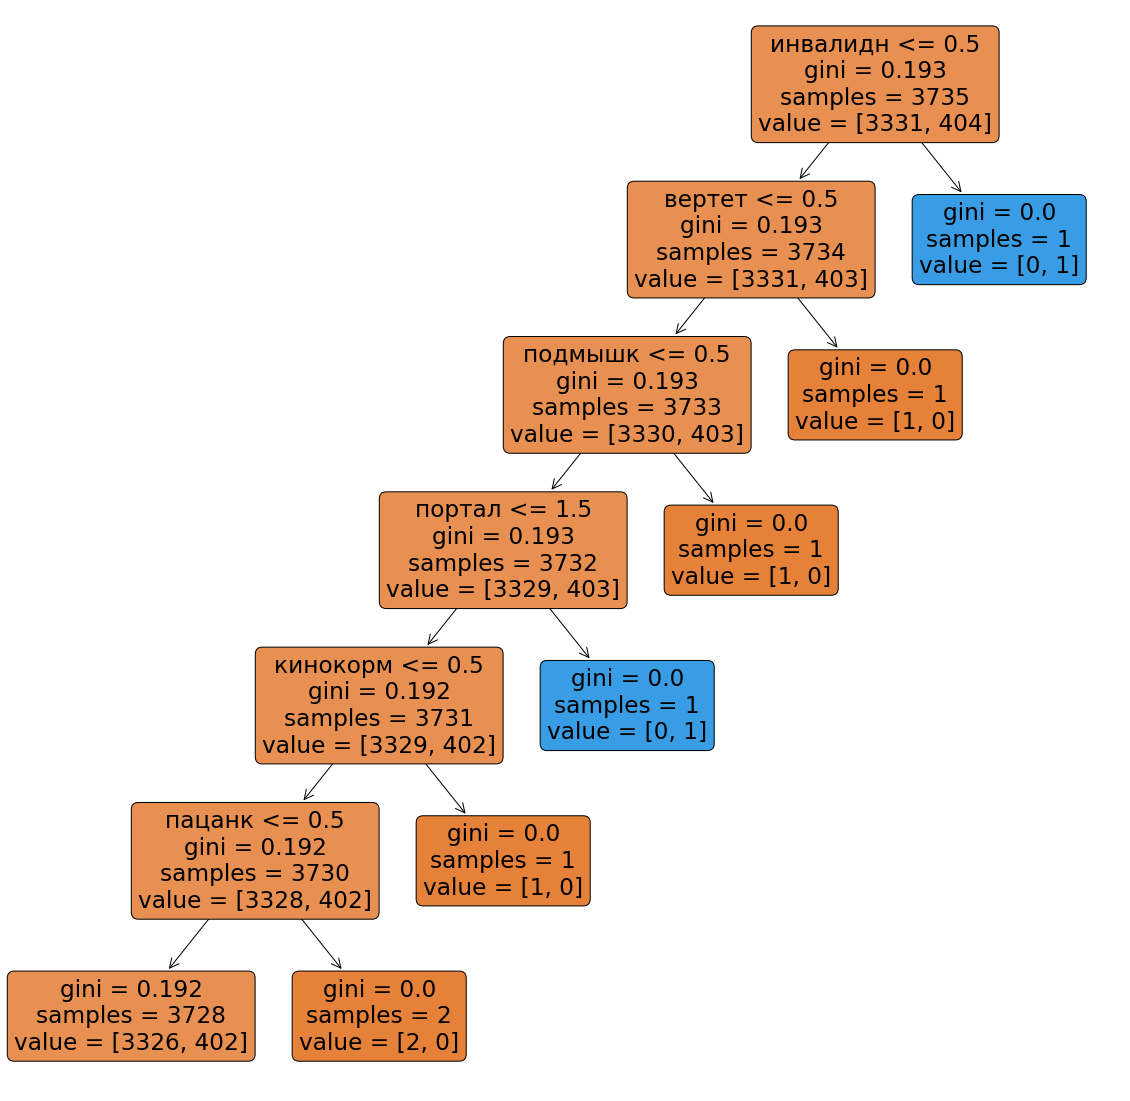

In [95]:
plt.figure(figsize=(20, 20))
tree.plot_tree(decision_tree=logit, 
               feature_names=feature_names,
               filled=True, 
               rounded=True)